In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
from datacube import helpers

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/home/547/ck9738/datacube-s2.conf')

In [3]:
#define nessisary gotiff handeling fuctions

import xarray, rasterio, numpy as np
def numpy_to_xarray(array, geobox, name=None):
    """Utility to convert ndarray to DataArray, using a datacube.model.GeoBox"""
    coords=[xarray.Coordinate(x, geobox.coords[x].values, attrs=dict(units=geobox.coords[x].units)) 
            for x in geobox.dims]
    return xarray.DataArray(array, coords=coords, attrs=dict(crs=geobox.crs), name=name)

def geopandas_to_xarray(table, geobox, name=None):
    """Rasterise (with reprojection)"""
    array = rasterio.features.rasterize(shapes=table.to_crs(geobox.crs._crs.ExportToProj4()).geometry,
                                        out_shape=(geobox.height, geobox.width),
                                        transform=geobox.affine)
    return numpy_to_xarray(array, geobox, name)

def rasterfile_to_xarray(file, geobox, name=None, nodata=True, num_bands=(1), X_band= 1):
    """Blit like
    """
    with rasterio.open(file) as src:

        #|assert src.indexes == num_bands # assume single band
        band = rasterio.band(src, X_band) # do not attempt to read entire extent into memory
        array = np.empty((geobox.height, geobox.width), dtype=band.dtype)
        rasterio.warp.reproject(source=band,
                                destination=array,
                                dst_crs=geobox.crs.crs_str,
                                dst_transform=geobox.affine,
                                dst_nodata=nodata)
    return numpy_to_xarray(array, geobox, name)

In [4]:
"""#define area
# open  shapfile and data loat from that

shapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'

#import project area shapefiles
project_area = gpd.read_file(shapefile_loc)

#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long
project_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)

#find the bounding box that contains all the queried projects
#addig 0.025 degrees to the bounding box to be certain the polygons are captured
coords = project_area.total_bounds
xmin, ymax, xmax, ymin =coords"""



"#define area\n# open  shapfile and data loat from that\n\nshapefile_loc='/g/data/u46/users/ck9738/Datasets/woody_files/test_area_outline.shp'\n\n#import project area shapefiles\nproject_area = gpd.read_file(shapefile_loc)\n\n#convert the shapefile to GDA94 lat-long coords so we can query dc_load using lat long\nproject_area['geometry'] = project_area['geometry'].to_crs(epsg=4283)\n\n#find the bounding box that contains all the queried projects\n#addig 0.025 degrees to the bounding box to be certain the polygons are captured\ncoords = project_area.total_bounds\nxmin, ymax, xmax, ymin =coords"

In [5]:
""" 
square 60 -149  'lat': (-33.107410, -33.216838),
near parks      'lon': (148.264306, 148.470191),

canberra east 62_-159
        'lat': (-35.219946, -35.404461),
        'lon': (149.12468, 149.413767),
        
canberra west 61_-159
        'lat': (-35.243523, -35.433887),
        'lon': (148.847028, 149.140130),


square 60_-155, Barwang
        'lat': (-34.382385, -34.577689),
        'lon': (148.425899, 148.734517),
        
Lake Wombah 49 -129
        'lat': (-28.85916, -29.11364),
        'lon': (144.73454, 145.023037),

"""

" \nsquare 60 -149  'lat': (-33.107410, -33.216838),\nnear parks      'lon': (148.264306, 148.470191),\n\ncanberra east 62_-159\n        'lat': (-35.219946, -35.404461),\n        'lon': (149.12468, 149.413767),\n        \ncanberra west 61_-159\n        'lat': (-35.243523, -35.433887),\n        'lon': (148.847028, 149.140130),\n\n\nsquare 60_-155, Barwang\n        'lat': (-34.382385, -34.577689),\n        'lon': (148.425899, 148.734517),\n        \nLake Wombah 49 -129\n        'lat': (-28.85916, -29.11364),\n        'lon': (144.73454, 145.023037),\n\n"

In [6]:
#load sentinal data
sensors= ['s2a_ard_granule'] #pick the sentinal satelites you want

bands_of_int =['blue', 'green', 'red'
             #'rededge1', 
             #'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2', 'pixel_quality'
              ] #pick the sentinal bands that you want, here i am just using visible light  

query = {
        'lat': (-35.243523, -35.433887),
        'lon': (148.847028, 149.140130),
        'output_crs': 'EPSG:3577',
        'resolution': (-10, 10),
        'time':('2016-01-01', '2016-03-30')
        }
      
# use s2b_ard_granule 	 for S2B
data_sent = s2aws.load(product='s2a_ard_granule', measurements=bands_of_int, group_by='solar_day', **query)
#clear_pixels = np.logical_and(data_sent.pixel_quality != 2, data_sent.pixel_quality != 3)

#data_sent = data_sent.where(clear_pixels)


In [7]:
data_sent

<xarray.Dataset>
Dimensions:  (time: 10, x: 2918, y: 2451)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01T00:09:15.704000 ...
  * y        (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x        (x) float64 1.523e+06 1.523e+06 1.523e+06 1.523e+06 1.523e+06 ...
Data variables:
    blue     (time, y, x) int16 317 304 304 295 308 293 287 291 285 297 301 ...
    green    (time, y, x) int16 384 383 392 387 412 406 392 399 386 376 362 ...
    red      (time, y, x) int16 364 386 376 363 390 379 364 368 355 363 340 ...
Attributes:
    crs:      EPSG:3577

In [8]:
"""#generate sentinal geomedian?
#cast the data to float numbers so geomedian calculation will work
data_sent_flt = data_sent.astype(float,casting='safe')

#create geomedian for data
Sentinal_gm=GeoMedian().compute(data_sent_flt)"""


"#generate sentinal geomedian?\n#cast the data to float numbers so geomedian calculation will work\ndata_sent_flt = data_sent.astype(float,casting='safe')\n\n#create geomedian for data\nSentinal_gm=GeoMedian().compute(data_sent_flt)"

In [9]:
Sentinal_time = data_sent.isel(time=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


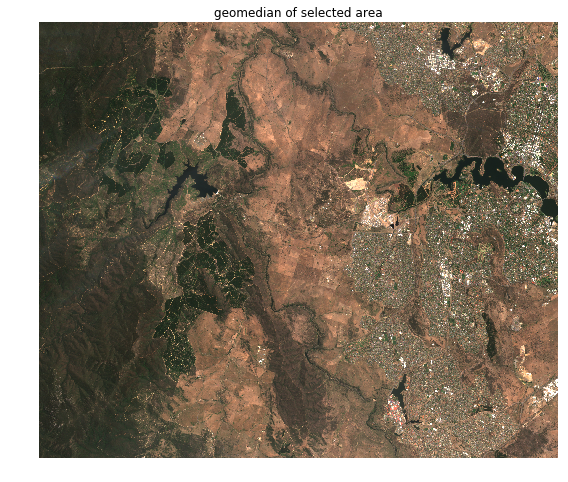

In [10]:
#plot RGB image
#Prepare geomedian imagery for plotting

rgb = Sentinal_time.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(8,8)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('geomedian of selected area') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [11]:
group_smad_green = {}
band_list = [1,2,3]

In [12]:
#load smad/green product for area
for band in band_list:#49 -129

    data = rasterfile_to_xarray('/g/data/u46/users/dxr251/woody-v6/woody_61_-159.tif', data_sent.geobox, num_bands=(1,2,3), X_band=band)
    group_smad_green[band] = data

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  import sys


In [13]:
group_smad_green

{1: <xarray.DataArray (y: 2451, x: 2918)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
   * x        (x) float64 1.523e+06 1.523e+06 1.523e+06 1.523e+06 1.523e+06 ...
 Attributes:
     crs:      EPSG:3577, 2: <xarray.DataArray (y: 2451, x: 2918)>
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
 Coordinates:
   * y        (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
   * x      

In [14]:
data_smad_green = xr.concat([group_smad_green[1],group_smad_green[2],group_smad_green[3]], 'band')
ori_n,ori_y,ori_x=data_smad_green.shape
data_smad_green

<xarray.DataArray (band: 3, y: 2451, x: 2918)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
  * x        (x) float64 1.523e+06 1.523e+06 1.523e+06 1.523e+06 1.523e+06 ...
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

In [15]:
#transform into format to feed to algorithm
flat_smad_green = data_smad_green.stack(z=('y','x')) #we stack Y and X together to make the array 2D, where shape is 
                                                  # N_samples x N_features
    
flat_smad_green = flat_smad_green.transpose()#transpose so sample numbers is first dimention. This is what the machine 
flat_smad_green                              #learning algarithm wants 

<xarray.DataArray (z: 7152018, band: 3)>
array([[nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan],
       ...,
       [nan, nan, nan],
       [nan, nan, nan],
       [nan, nan, nan]], dtype=float32)
Coordinates:
  * z        (z) MultiIndex
  - y        (z) float64 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 -3.95e+06 ...
  - x        (z) float64 1.523e+06 1.523e+06 1.523e+06 1.523e+06 1.523e+06 ...
Dimensions without coordinates: band
Attributes:
    crs:      EPSG:3577

In [16]:
#load traning data
panda_training= pd.read_csv('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/training_datasets/ncas_truthed_landsat_124.csv',
                            usecols=(1,2,3,4))

panda_training

,class,1,2,3
0,0,0.003713,0.508305,0.498965
1,0,0.005193,0.577651,0.553511
2,0,0.005193,0.577651,0.553511
3,0,0.005193,0.577651,0.553511
4,0,0.009352,0.661980,0.591735
5,0,0.009352,0.661980,0.591735
6,1,0.004694,0.668501,0.624123
7,1,0.004694,0.668501,0.624123
8,1,0.004694,0.668501,0.624123
9,1,0.002938,0.536924,0.518079


In [17]:
training_features = panda_training.as_matrix(columns=['1','2','3']) #create Array of features for training
training_class = panda_training.as_matrix(columns=['class']) #create Array of classification answer for training
training_class

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [18]:
#define machine learning algarithm 
classify = ExtraTreesClassifier(bootstrap=False, max_depth=10, random_state=0)

classify.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180629/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=10, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
#classify area
results=classify.predict(flat_smad_green)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
#return results back to original shape
results_back = results.reshape(ori_y,ori_x)
results_xr = xr.DataArray(results_back,dims=('y', 'x'),name='results')
results_xr = results_xr.astype('int16')
results_xr

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)

plt.show()

In [ ]:
#add classification results to dataset
##replace with Geomediam 
Sentinal_time["class"] = results_xr
Sentinal_time
#add smad/green to dataset?

In [ ]:
#save dataset as netCDF to look at in QGIS
#write_geotiff(filename, dataset, profile_override=None, time_index=None)
#helpers.write_geotiff('/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/can_west_ncas124.tif',Sentinal_time)

In [ ]:
#turn into panda Dataframe for easy plotting
results_panda = pd.DataFrame(results, columns=['class'])

results_panda['1'] = array_topanda_s(data_smad_green[0])
results_panda['2'] = array_topanda_s(data_smad_green[1])
results_panda['3'] = array_topanda_s(data_smad_green[2])
#results_panda= results_panda.dropna(axis=0, how='any')
results_panda

In [ ]:
colours_class = pd.Series(results)
#colours_class = colours_class.replace(to_replace=[2,1,0],value=['blue','green','orange'])
colours_class = colours_class.replace(to_replace=[0,1,2],value=['darkseagreen','khaki',
                                                                    'forestgreen'])#for 5 classes
colours_class = colours_class.as_matrix()
colours_class

In [ ]:
results_panda.plot.scatter('1','2',c=colours_class, figsize=(12,12), alpha=0.1)
plt.title('scatter of classification result, smad vs max green')